In [10]:
# Import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats
import numpy as np

## Preparing data

In [11]:
walking_times = {} # Create an empty dictionary to store DataFrames for each building
walking_means = {} # Creating an empty dictionary to store means
walking_sd = {} # Creating an empty dictionary to store the standard deviation

# Using a loop to import and apply the data preparation too all buildings
for i in range(1, 6):
    filename = f"data/Walkingfrom_building{i}.txt"
    df = pd.read_csv(filename, header=None)
    
    df['distance'] = df[0].round()
    df = df[df['distance'] > 0]
    df['avg_speed'] = df[0] / df['distance']
    df.reset_index(drop=True)

    walking_means[f'I{i}'] = df["avg_speed"].mean()
    walking_sd[f'I{i}'] = df["avg_speed"].std()
    
    walking_times[f'I{i}'] = df # Store DataFrame for building i in the dictionary

# Access the DataFrame for building i with the key 'I{i}'
I1 = walking_times['I1']
I2 = walking_times['I2']
I3 = walking_times['I3']
I4 = walking_times['I4']
I5 = walking_times['I5']


## Making a function for fitter

In [12]:
def fitter_test(df, column_name, out_name):
    values = df[column_name].values
    
    avg = values.mean()
    sd = values.std()
    Max = values.max()
    Min = values.min()

    hist = sns.displot(data=df, x=column_name, kind="hist", bins = 30, aspect = 2)

    # Fitting various distributions to the observed data
    f = Fitter(values, distributions =['norm', 'expon', 'gamma', 'erlang', 'beta'])
    f.fit()
    y = f.summary()
    print(y)
    # Print the parameters
    for el in y.index: 
        print(f'parameters for {el}: {f.fitted_param[el]}')
        
    # KS test Exponential
    teststat, pvalue = stats.kstest(values, 'expon', args=(f.fitted_param['expon'][0],f.fitted_param['expon'][1]))
    print("KSTest for exponential")
    print(f"KS statistics = {teststat}")
    print(f"p-value = {pvalue}")

    res_expon= stats.goodness_of_fit(stats.expon, values, known_params={'loc':f.fitted_param["expon"][0], 'scale':f.fitted_param["expon"][1]},statistic='ks')
    print(f"p-value goodness_of_fit= {res_expon.pvalue}")
    plt.figure(3)
    res_expon.fit_result.plot()
    plt.title(f"Fitted expon PDF and Histogram for {out_name}")
    print("")


    # KS test for Beta
    fit1 = stats.beta.fit(values,method="MLE")

    res_beta= stats.goodness_of_fit(stats.beta, values, known_params={'a':fit1[0], 'b': fit1[1], 'loc': fit1[2], 'scale':fit1[3]},statistic='ks')
    print(f"p-value goodness_of_fit= {res_beta.pvalue}")
    plt.figure(4)
    plt.xlim([0.5, 1.5])
    res_beta.fit_result.plot()
    plt.title(f"Fitted beta PDF and Histogram for {out_name}")
    print("")

    # KS Test for Gamma
    fit_params = stats.gamma.fit(values, floc=0)
    teststat, pvalue = stats.kstest(values, 'gamma', args=(fit_params))
    print("KSTest for gamma")
    print(f"KS statistics = {teststat}")
    print(f"p-value = {pvalue}")

    res_gamma= stats.goodness_of_fit(stats.gamma, values, known_params={'a':fit_params[0], 'loc':fit_params[1], 'scale':fit_params[2]},statistic='ks')
    print(f"p-value goodness_of_fit= {res_gamma.pvalue}")
    plt.figure(5)
    plt.xlim([0.5, 1.5])
    res_gamma.fit_result.plot()
    plt.title(f"Fitted gamma PDF and Histogram for {out_name}")


    with open(f"output/{out_name}-param.txt", 'w') as file:
        file.write(f'\nMean = {avg}\nSD = {sd}\nMin = {Min}\nMax = {Max}\nexpon = {res_expon.pvalue}\nbeta = {res_beta.pvalue}\ngamma = {res_gamma.pvalue}')

    y = y.round(4)
    y.to_csv(f"output/{out_name}-dist.txt", sep='\t', index=True)


In [13]:
with open('output/walking_sd.txt', 'w') as file:
    for key, value in walking_sd.items():
        file.write(f"{key}: {value}\n")

with open('output/walking_means.txt', 'w') as file:
    for key, value in walking_means.items():
        file.write(f"{key}: {value}\n")

## Using the function for all buildings

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


        sumsquare_error         aic          bic  kl_div  ks_statistic   
erlang        35.929600  237.275095 -3060.709839     inf      0.085079  \
gamma         35.931225  237.266244 -3060.667197     inf      0.085078   
beta          36.187039  239.832648 -3047.128189     inf      0.084597   
norm          37.246763  224.196674 -3033.607526     inf      0.093753   
expon        228.459215   62.503160 -1323.201055     inf      0.409649   

            ks_pvalue  
erlang   2.184102e-06  
gamma    2.184712e-06  
beta     2.550504e-06  
norm     1.153544e-07  
expon   1.298436e-143  
parameters for erlang: (143.894189014819, -0.6339610320175959, 0.011325644958162318)
parameters for gamma: (143.829792024005, -0.6336258437133373, 0.011328380234618185)
parameters for beta: (109.68559207638407, 4765351.856197797, -0.43175848832462327, 62022.19605401535)
parameters for norm: (0.9957337340007559, 0.13648326231606028)
parameters for expon: (0.5064476173455601, 0.48928611665519584)
KSTest for ex

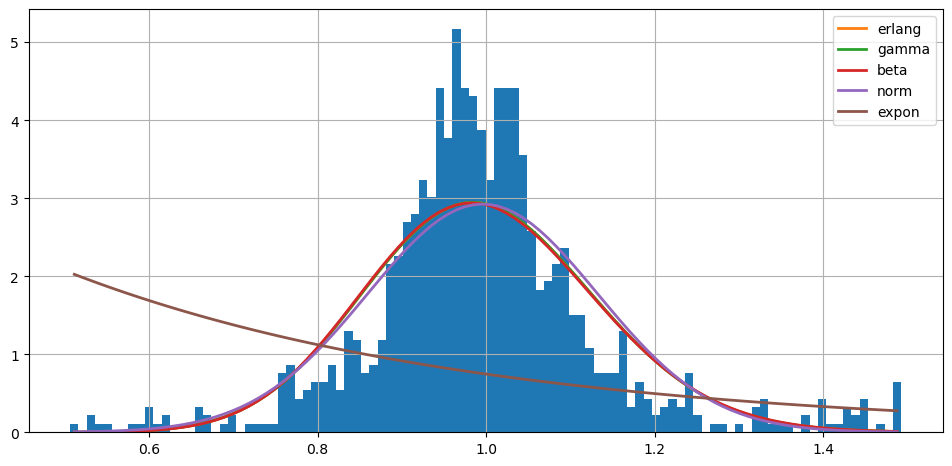

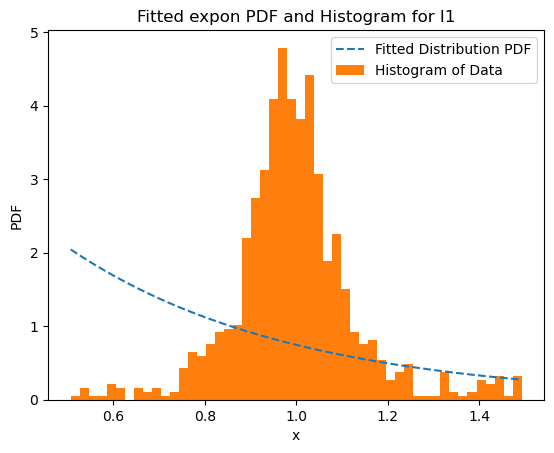

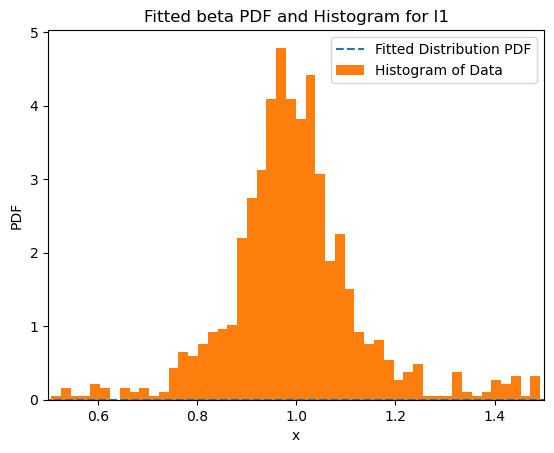

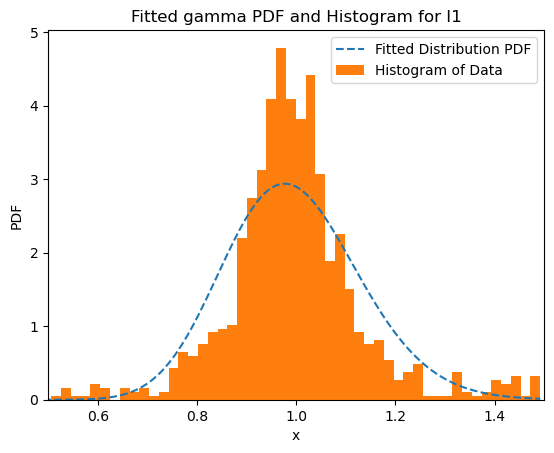

In [14]:
fitter_test(I1,"avg_speed","I1")

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


        sumsquare_error         aic          bic  kl_div  ks_statistic   
beta          53.013762  526.192311 -2842.854169     inf      0.096382  \
norm          53.214538  520.510940 -2852.919557     inf      0.095828   
gamma         53.220440  529.297379 -2845.919929     inf      0.099945   
erlang        53.988696  523.748916 -2831.831416     inf      0.100825   
expon        368.180516   56.888961  -951.559944     inf      0.469006   

            ks_pvalue  
beta     2.122623e-08  
norm     2.619442e-08  
gamma    5.322555e-09  
erlang   3.751936e-09  
expon   8.541752e-199  
parameters for beta: (2722.3110187347065, 13931.736315543265, -4.583301622120488, 34.1743245425534)
parameters for norm: (1.0029147475915459, 0.09798642045357892)
parameters for gamma: (490.5322617376812, -1.1704929318992865, 0.0044296940390365115)
parameters for erlang: (436.849559285669, -1.0578407879215512, 0.004716402818374862)
parameters for expon: (0.5258649394315649, 0.477049808159981)
KSTest for expo

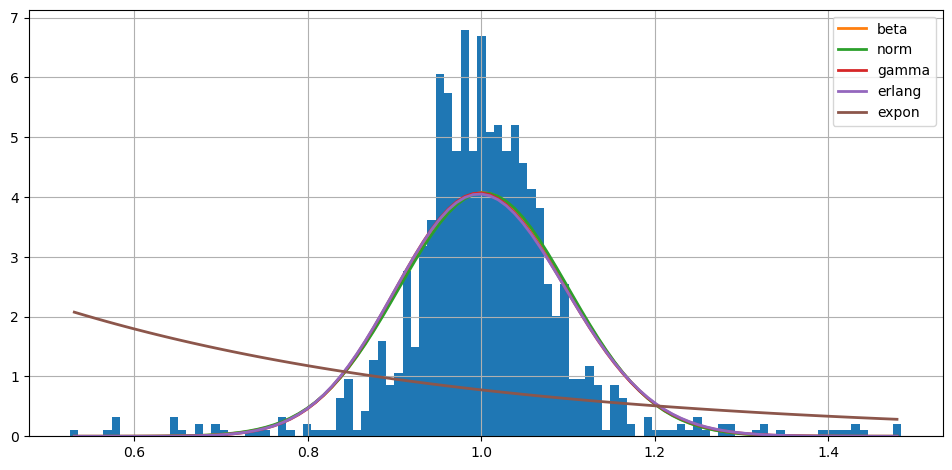

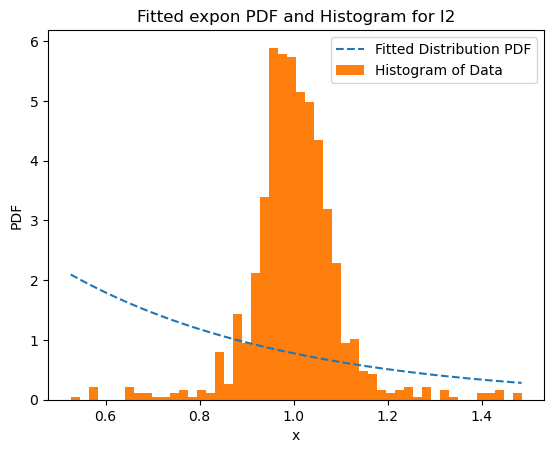

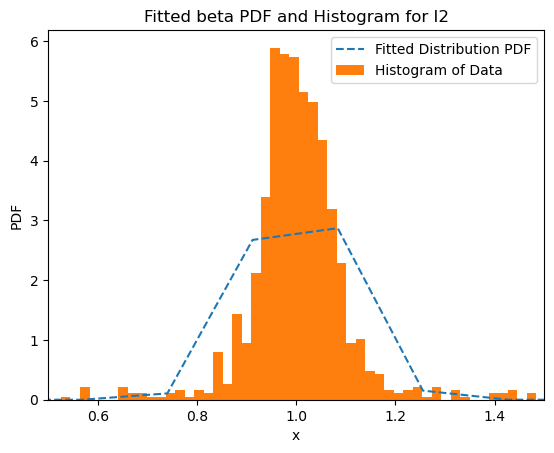

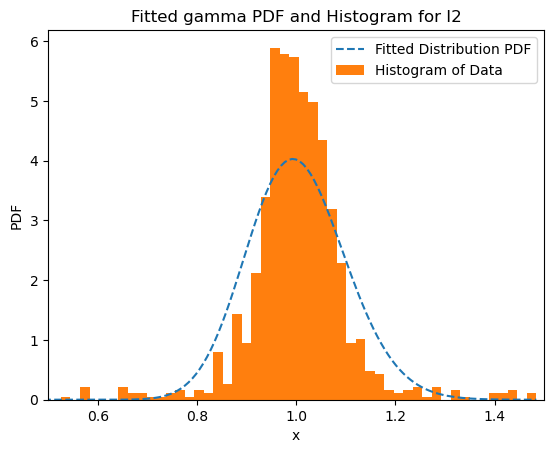

In [15]:
fitter_test(I2,"avg_speed","I2")

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


        sumsquare_error         aic          bic  kl_div  ks_statistic   
beta          31.186140  380.874844 -3311.127173     inf      0.068538  \
norm          31.220285  376.807651 -3323.821266     inf      0.068363   
gamma         31.266748  380.075151 -3315.498938     inf      0.070030   
erlang        31.376749  378.869201 -3312.088823     inf      0.070582   
expon        266.293871   64.274124 -1242.451285     inf      0.438252   

            ks_pvalue  
beta     2.070832e-04  
norm     2.169445e-04  
gamma    1.383474e-04  
erlang   1.188949e-04  
expon   3.056694e-170  
parameters for beta: (10374.452989799822, 48107.75903666217, -11.940388347176423, 72.90762972441703)
parameters for norm: (0.9930625059161867, 0.11520280193783163)
parameters for gamma: (811.6580212385718, -2.289335229200095, 0.00404385132781611)
parameters for erlang: (845.1584809173364, -2.3599758477004125, 0.0039669910437026504)
parameters for expon: (0.5027626446244162, 0.4902998612917705)
KSTest for exp

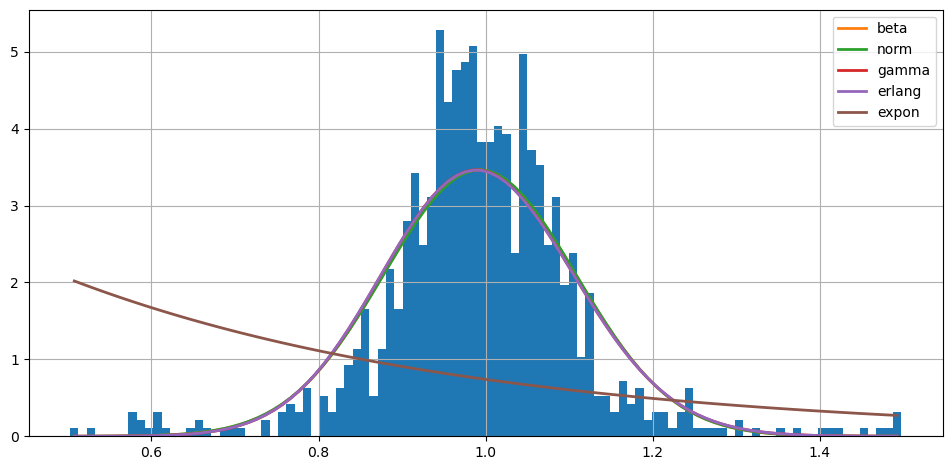

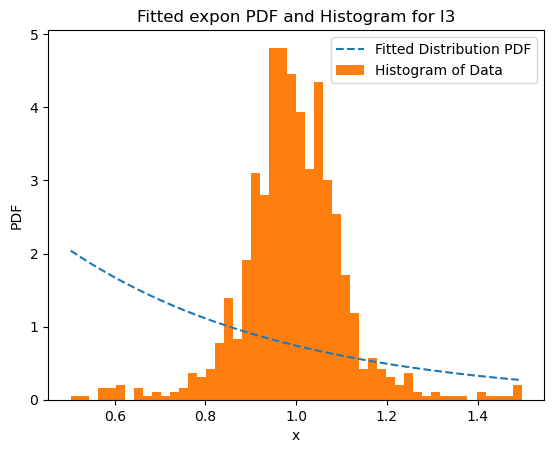

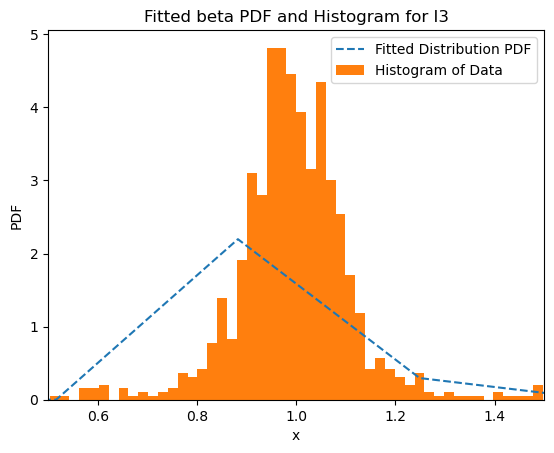

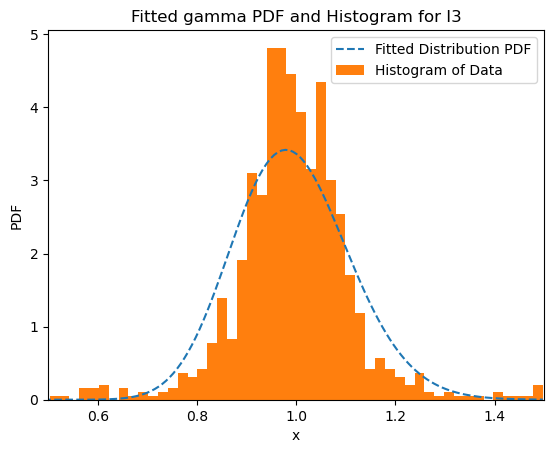

In [16]:
fitter_test(I3,"avg_speed","I3")

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


        sumsquare_error         aic          bic  kl_div  ks_statistic   
erlang        45.999718  359.663133 -2932.524041     inf      0.092273  \
beta          46.011615  361.616463 -2925.397205     inf      0.092769   
norm          46.012362  357.605646 -2939.133999     inf      0.092761   
gamma         46.028954  359.467273 -2931.908378     inf      0.092502   
expon        298.725888   60.480430 -1126.506806     inf      0.451962   

            ks_pvalue  
erlang   1.247607e-07  
beta     1.043370e-07  
norm     1.046314e-07  
gamma    1.148821e-07  
expon   3.015822e-181  
parameters for erlang: (16572.81854925039, -13.770476876376563, 0.0008914467933755876)
parameters for beta: (822183.8055015013, 723908.4151396726, -151.026980630568, 285.88851470580437)
parameters for norm: (1.003345525401798, 0.11472945309880844)
parameters for gamma: (16854.399832226583, -13.89833341667157, 0.0008841435916551303)
parameters for expon: (0.5128694108774687, 0.49047611452432927)
KSTest for ex

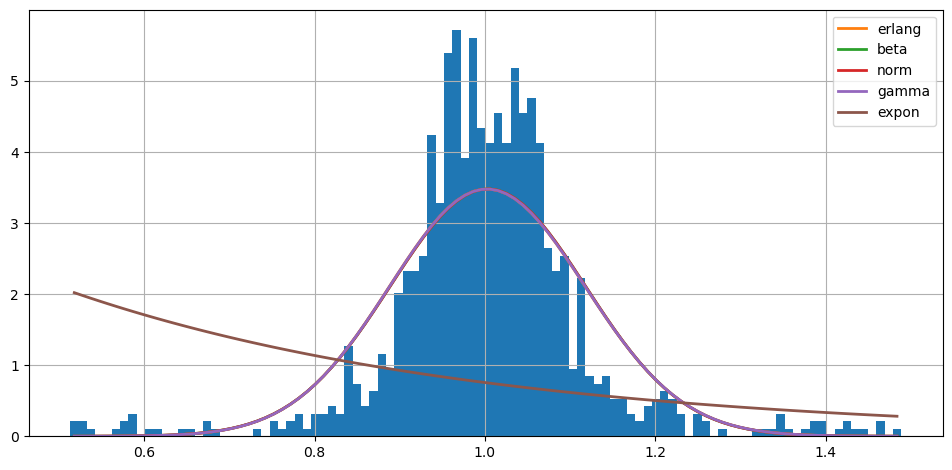

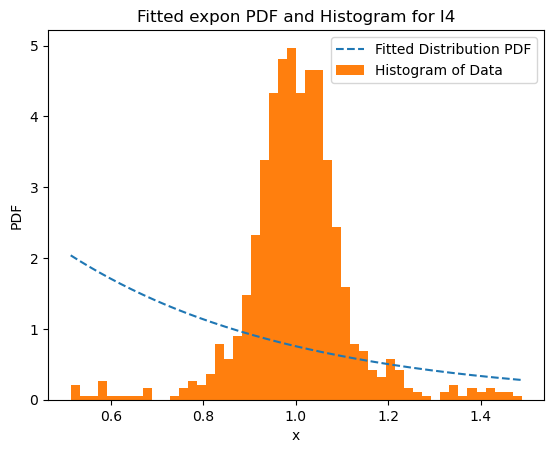

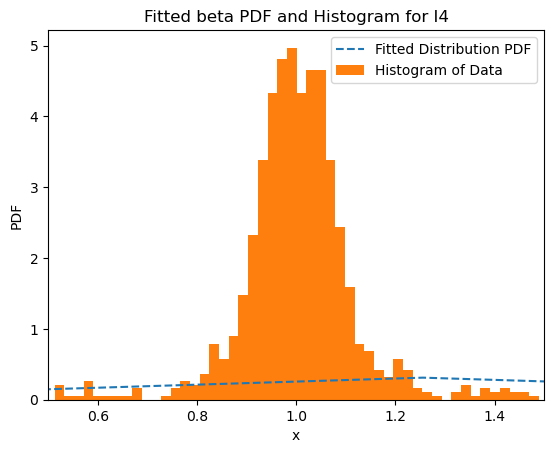

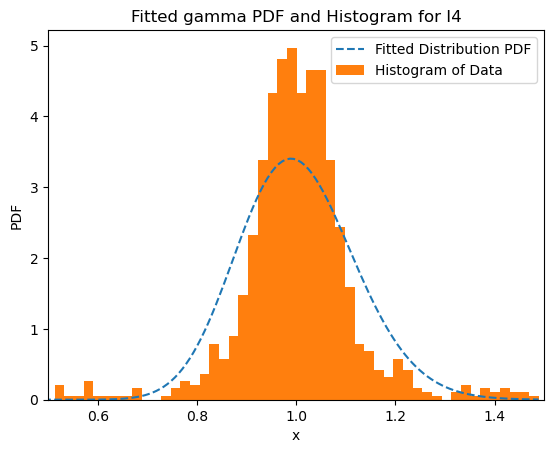

In [17]:
fitter_test(I4,"avg_speed","I4")

Fitting 5 distributions: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


        sumsquare_error         aic          bic  kl_div  ks_statistic   
beta          37.390411  550.178558 -3160.483755     inf      0.077195  \
norm          38.829097  525.736368 -3137.365511     inf      0.081064   
gamma        333.432411  107.440409 -1029.666945     inf      0.453443   
erlang       334.475641  106.797644 -1026.614918     inf      0.448590   
expon        342.973126   57.012147 -1008.988390     inf      0.474202   

            ks_pvalue  
beta     1.645027e-05  
norm     4.944558e-06  
gamma   5.301586e-184  
erlang  6.977548e-180  
expon   3.009286e-202  
parameters for beta: (330.46152655244157, 8433.825924330882, -0.8013243915742276, 47.88772567866127)
parameters for norm: (1.004397099364973, 0.09769161999523784)
parameters for gamma: (0.7929621973356618, 0.522112540530906, 1.2582618029797046)
parameters for erlang: (0.786123839185621, 0.522112540530906, 1.2542002317104202)
parameters for expon: (0.5221125405309062, 0.48228455883406673)
KSTest for exponenti

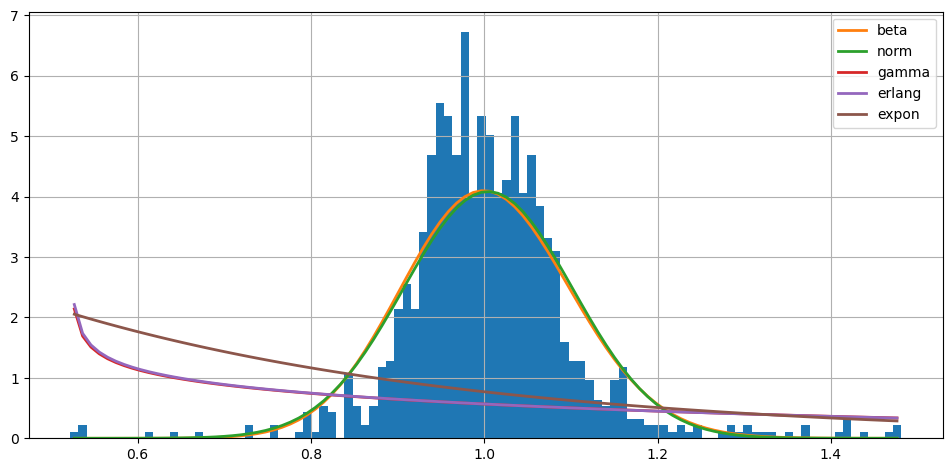

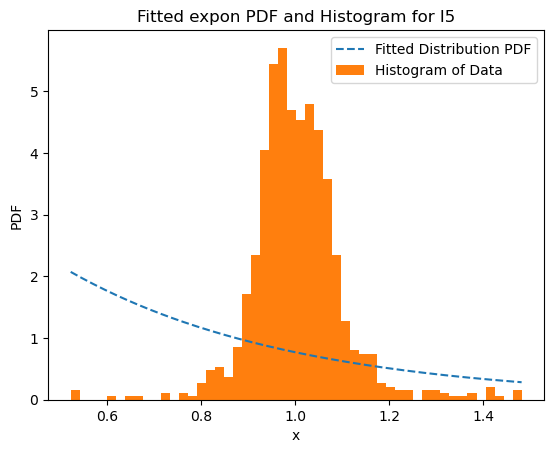

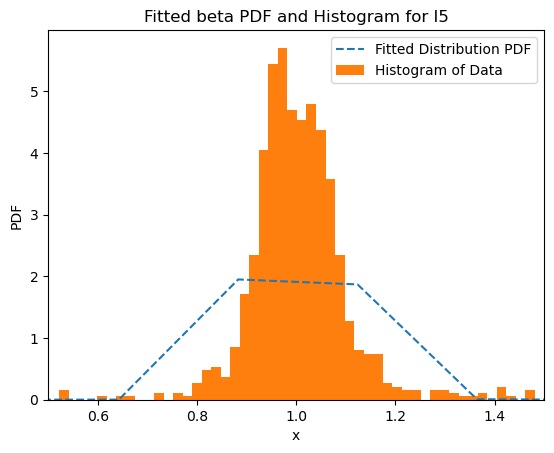

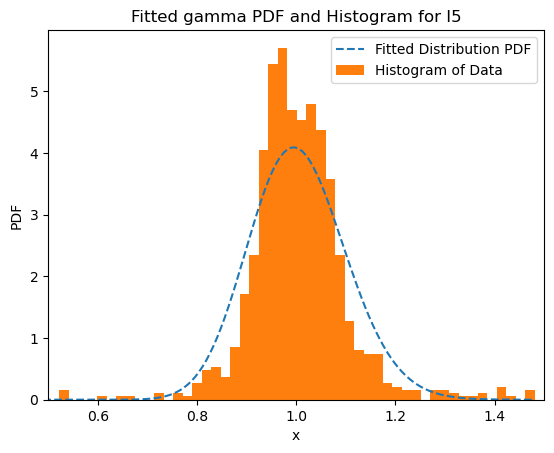

In [18]:
fitter_test(I5,"avg_speed","I5")